In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Short Term Load Forecast

Now that we have a clean and accesible dataset, lets do some EDA prior to building the forecaster class.

In [3]:
df = pd.read_csv('data/cleaned_dataset.csv', index_col=0, parse_dates=True)

Lets plot the high level trend.

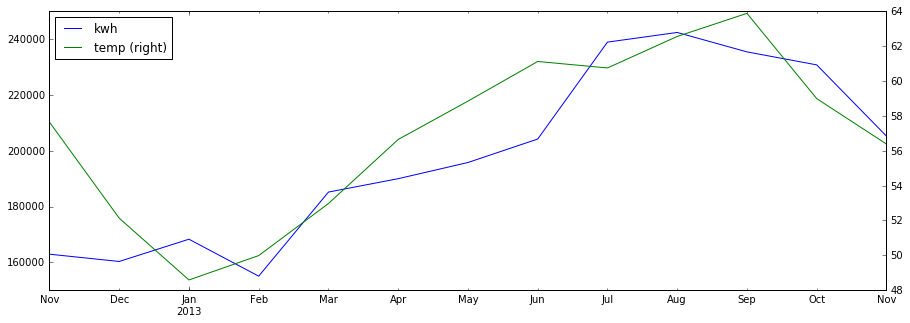

In [4]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)

df.resample('1M').sum()[['kwh']].plot(ax = ax_)
df.resample('1M').mean()[['temp']].plot(ax = ax_, secondary_y = True)

In [9]:
monthly_kwh = df.resample('1M').sum()['kwh']
monthly_temp = df.resample('1M').mean()['temp']

monthly_kwh.corr(monthly_temp)

0.83179734309666942

- As we would expect the correlation between kwh-temp is very strong, specially at a lower time resolution. 

In [ ]:
# Interesting difference between Nov-2012 and Nov-2013, lets dig deeper.
df.resample('1M').sum()[['kwh','temp']].kwh[-1] / df.resample('1M').sum()[['kwh','temp']].kwh[0] -1 

- So the total consumption increased more than 20%, where as the mean temperature remained relatively consant. 

- Lets do some statitstics to see if this is behavioral change or perhaps somewhere during the year a significant business event happend(ie. merging two nodes/utilites).

Assuming a gaussian distribution, lets build confidence 95 confidence intervals.

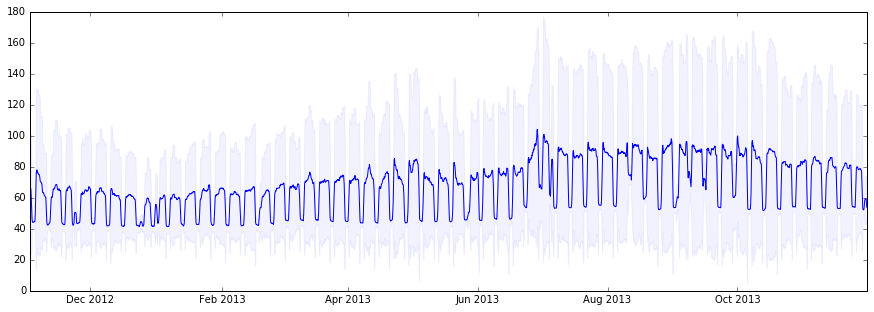

In [120]:
# Plot daily rolling averages and 95% C.I.
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)
ma = df.kwh.rolling(96).mean()
mstd = df.kwh.rolling(96).std()
plt.plot(ma.index, ma, 'b', axes = ax_)
plt.fill_between(mstd.index, ma-1.96*mstd, ma+1.96*mstd, color='b', alpha=0.05, axes=ax_)

- Variance is lower in non-summer months (expect the forecast accuracy to be higer for this period). 
- Summer consumption increases both in magnitude and variance (expect this load behavior harder to predict).
- There is no strong evidence there was a special event; more data would be useful to grasp onto the evolution / yearly trends.
- Summer-autumn season peak is greater than winter's, suggests demand is primarily driven by cooling appliances.

#### Moving ahead into the regression problem. 

Forecasting loads can be done either with a classic statistical method (eg. ARIMA, Multiple Linear Regression) or with a Machine Learning approach (eg. Support Vector Machines, Random Forests, Neural Networks).

Lets explore a bit more the dataset and define the method to use. 

If we were to do a multiple linear regression, it would be useful to see the relationship between variables so lets do that. 

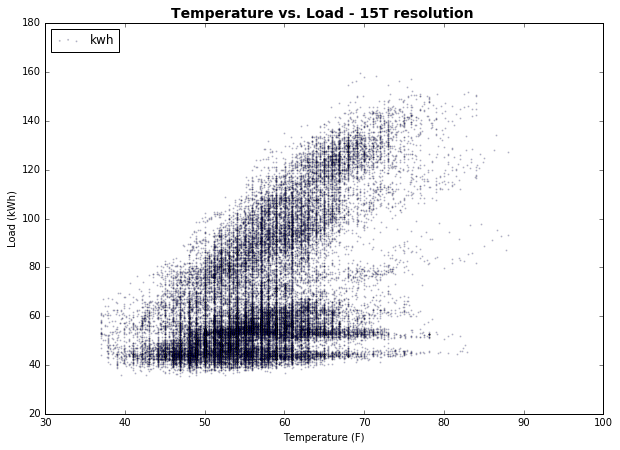

In [80]:
# Plotting general temp-load relationship.

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)

res = '15T'

plt.scatter(df.resample(res).mean().temp ,df.resample(res).sum().kwh, alpha = 0.2, s=1, c='b')

ax.set_title("Temperature vs. Load - %s resolution " %res, fontsize =14, fontweight='bold')
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Load (kWh)")

leg = plt.legend(frameon = True, loc = 'upper left', ncol =2, fontsize = 12)


There's notably:

1) some sort of linear or polynomial relationship between 60-160 kwh range.

2) the load range 40-60 kwh doesn't seem to be explained linearly - however this may have to do with human consumption patterns rather than the relationship.

This graph turns out to be only partially useful, we need to dig deeper at this different granularities for detail and help us understand.

In [106]:
def relationship (df, res, timeframe, subtitle = ''):
    '''
    Plots a matrix given a time resolution and timeframe to consider.
    
    Parameters
    ----------
    df: DataFrame
        Dataset.
    res: str
        Resolution to resample dataset.
    timeframe: str
        Timeframe to plot (ie. 'Hour', 'Month').
        
    subtitle: str
        Subtitle to describe plot.
    
    Returns
    -------
    Plots: matplotlib object
        
    '''
    
    x = df.resample(res).mean().temp 
    y = df.resample(res).sum().kwh
        
    if timeframe == 'Month':
        plots_per_row = 3
    elif timeframe == 'Hour': 
        plots_per_row = 6
            
    plots_per_col = 4
    
    fig, axes = plt.subplots(plots_per_col, plots_per_row, sharex=True, sharey=True, figsize=(15,7))
        
    #Initialize a period counter.
    
    period_counter = 0
    
    for i in range(plots_per_col):
        for j in range(plots_per_row):
            # Create mask to filter time period.
            if timeframe == 'monthly':
                mask =  x.index.month == period_counter
            else: 
                mask = x.index.hour == period_counter
                        
            axes[i,j].scatter(x[mask], y[mask], s=1, alpha =0.3)           
            axes[i,j].set_title('%s : %d'% (timeframe ,period_counter+1))

            period_counter += 1
    
    # Set common labels
    fig.text(0.5, 0.04, 'Temperature (F)', ha='center', va='center')
    fig.text(0.06, 0.5, 'Load (kWh)', ha='center', va='center', rotation='vertical')
    
    # Set title to figure
    fig.suptitle("Temperature vs. Load Relationship - %s resolution %s" %(timeframe, subtitle), fontsize = 14, fontweight = 'bold')


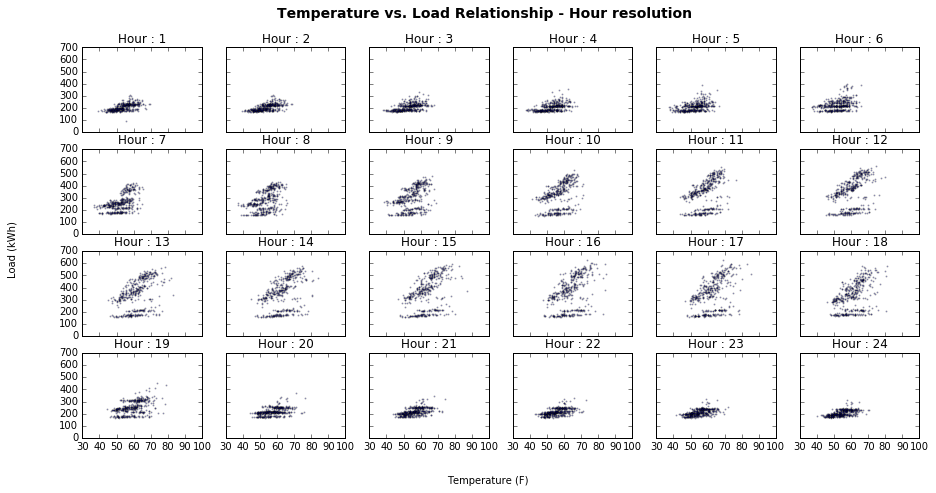

In [107]:
# Lets see hour relationship 

relationship(df, '1H', 'Hour')

... this is more interesting 
- Hours 10-12 seem to be have a polynomial relationship.

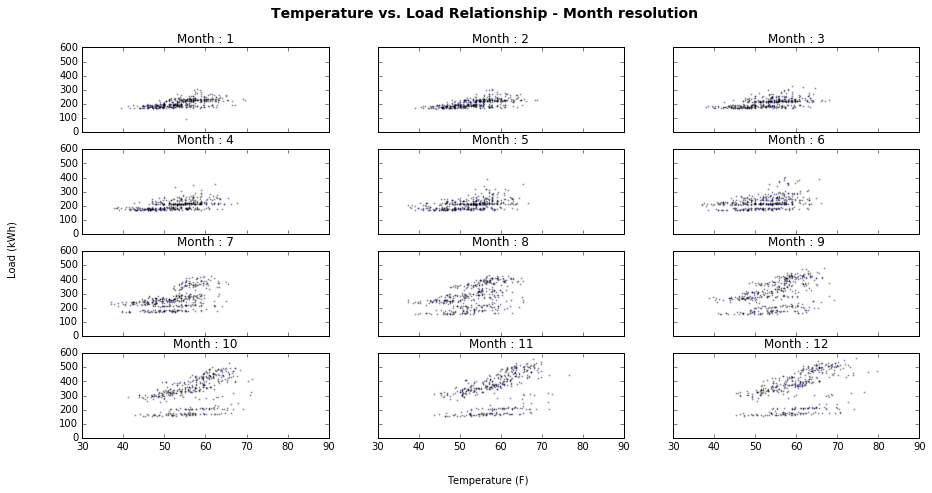

In [108]:
relationship(df, '1H', 'Month')

#### I feel the hourly plots would provide further insight into this non-linearity if we segment into summer / non-summer; lets look into that.

In [146]:
# Create a datatimeindex.
winter_index = pd.DatetimeIndex(start = '2012-12-01', end = '2013-03-21', freq = '15T')
df_winter = df[df.index.isin(winter_index)]
df_summer = df[~df.index.isin(winter_index)]

In [147]:
print 'Winter months',set(df_winter.index.month)
print 'Summer months',set(df_summer.index.month)

Winter months set([1, 2, 3, 12])
Summer months set([3, 4, 5, 6, 7, 8, 9, 10, 11])


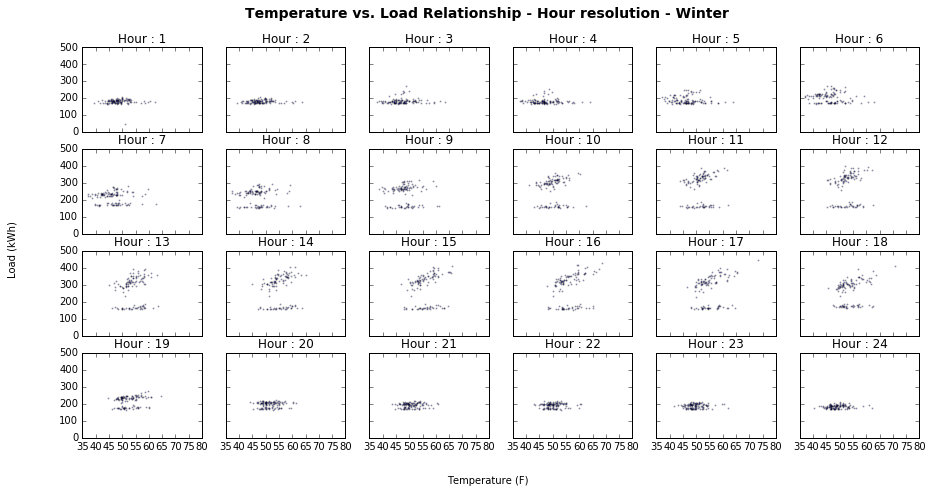

In [148]:
relationship(df_winter, '1H', 'Hour', '- Winter')

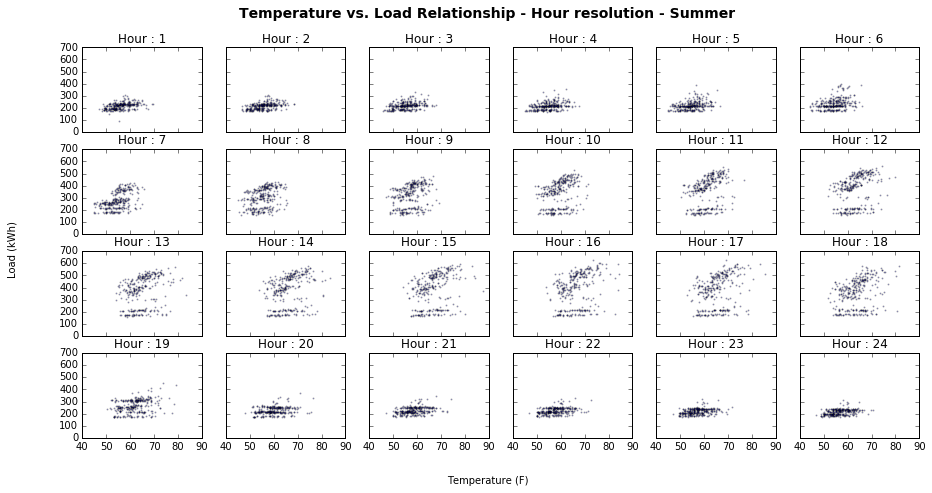

In [149]:
relationship(df_summer, '1H', 'Hour', '- Summer')

- The non-linearity I believe comes from human consumption patterns/activity.

#### Its also notable to see load is relatively static from 1-6 and 19-24, this resembles work hours and suggests its a commercial load.

Before building the model, I feel it would also be important to undertand the interaction between hours-days-load. Lets plot a similar analysis.

In [156]:
work_days_mask = np.in1d(df.index.dayofweek, np.array([1,2,3,4,5]))
df_weekdays = df[work_days_mask]
df_weekends = df[~work_days_mask]

In [158]:
print 'weekdays', set(df[work_days_mask].index.dayofweek) # Sanity check.
print 'weekends', set(df[~work_days_mask].index.dayofweek)

weekdays set([1, 2, 3, 4, 5])
weekends set([0, 6])


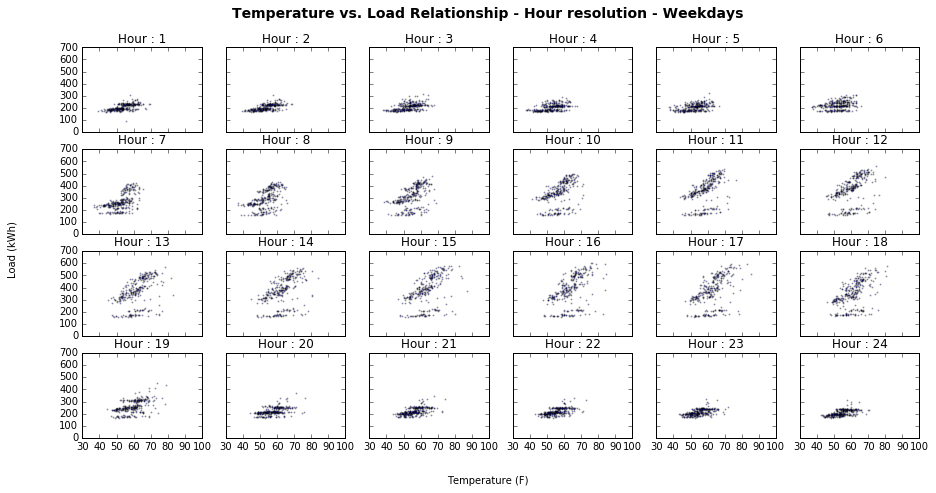

In [159]:
relationship(df_weekdays, '1H', 'Hour', '- Weekdays')

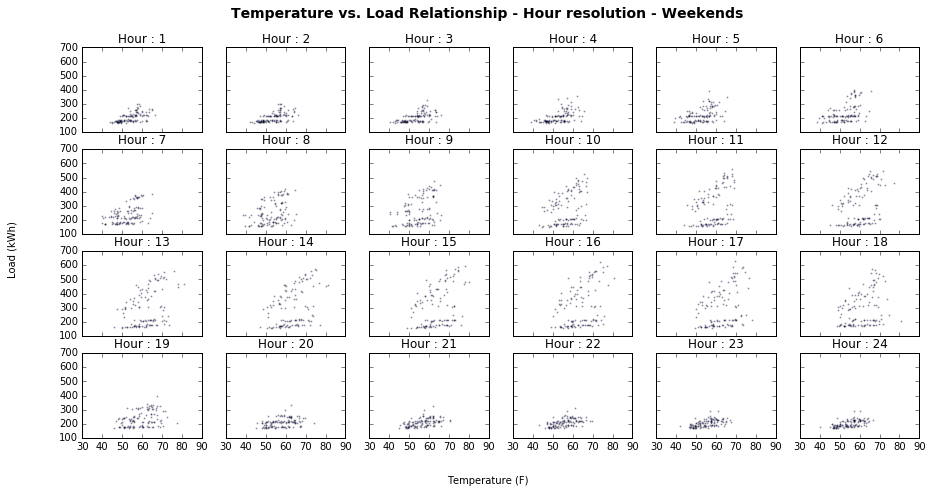

In [160]:
relationship(df_weekends, '1H', 'Hour', '- Weekends')

Obviously, there is less density on weekends but still we see some activity 9am-6pm. 
We don't see the polynomial curves trending during mid-day. 

Considerations for model 
------------------------

If time allows, I will try two models: MLR and a Random Forest.

Given this overview and related literature, building a MLR requires to consider multiple effects:

#### Multiple Linear Regression

Features:

1) Chronological trend - the mean load tends to increase over time (this feature is very straight forward, first datapoint in training dataset would be numbered 1, the second 2 and so forth until n points).

> feature: 1 -> n (int) data points in training dataset.

2) Consider polynomials with order 1 - 3 to describe temperature .

> Temp (float)

> Temp^2 
 
> Temp^3

3) Class variables at least for Month, Weekday and Freq period (in this case its 15-min intervals).

> Num. of Month (int)

> Day of Week (int)

> 1 - 96 for a 24 hour period given 15-min interval (int)

4) Literature also suggests the following cross effects yield better accuracy.

> Hour * Day of Week

> Temp * Month (1-3 polynomials)

> Temp * Hour (1-3 polynomials)

#### Random Forest

Among machine learning techniques, I want to try random forests:

- From a computationally point of view, they can be indepedently grown and thus parallelized to decrease training timing. 

- Although I notice Neural Networks and SVMs are more popular, they are also more time consuming to tune  -- RF most important parameters are attribute selection and # of trees. 

- Resarch suggests the load at a certain hour is really close to the load at the same hour of the previous day, rather than to the previous hour. Hence I will build independent models for a time interval (ie. 96 models for 15-min). 

Since there is no general convention to choose inputs, I will try the following and optimize if possible.

Features:

To predict on day (d) and time interval (h): 

1) Class variables at least for Month, Weekday and Freq period (in this case its 15-min intervals).

> Num. of Month (int)

> Day of Week (int)

> 1 - 96 for a 24 hour period given 15-min interval (int)

2) Min. and Max. temp of day d (NOTE: For out-of-sample forecasting, a weather forecast will also be required)

3) Load of day d-1 at time interval h

4) Morning load peak of d-1

5) Evening load peak of d-1